In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from util.lexicon_dataloader import LexiconDataLoader
from util.corpus_dataloader import CorpusDataLoader, LyricsTokenizer
from model.lexicon_model import Lexicon

In [2]:
LEXICON_PATH = "data/VnEmoLex.xlsx"
CORPUS_PATH = "data/corpus.csv"

In [3]:
lexicon = LexiconDataLoader(LEXICON_PATH)
corpus = CorpusDataLoader(CORPUS_PATH)

Lexicon loaded: 10626 words.
Corpus loaded: 62275 records.


In [4]:
tokenizer = LyricsTokenizer()
dataframe = tokenizer.transform(corpus.data)

Tokenizing 'lyrics' column...
Tokenization complete.


In [5]:
model = Lexicon(lexicon_dict=lexicon.data)
results = model.predict_dataset(
    dataframe, 
    tokenized_col_name="lyrics_tokenized"
)

Processing: 100%|██████████| 62275/62275 [00:06<00:00, 9843.89it/s] 


In [6]:
results.to_csv("data/lexicon_predicted_dataset.csv", index=False)

In [7]:
#remove year that are NaN and 0
results = results[results['year'].notna()]
results = results[(results['year'] != 0) & (results['year'] > 1900)]

TEST HERE

In [8]:
manually_labeled = pd.read_csv("data/manually_labeled.csv")

# Name column change
manually_labeled = manually_labeled.rename(columns={"text_segment": "lyrics_tokenized"})
lexicon_predicted_dataset = pd.read_csv("data/lexicon_predicted_dataset.csv")

In [9]:
lexicon_predicted_dataset.columns

Index(['title', 'composers', 'lyricists', 'year', 'genres', 'lyrics', 'urls',
       'source', 'note', 'lyrics_tokenized', 'top_emotion', 'word_count',
       'positive', 'negative', 'anger', 'anticipation', 'disgust', 'fear',
       'joy', 'sadness', 'surprise', 'trust'],
      dtype='object')

In [10]:
removing_columns = [
    # 'id',
    # 'title',
    # 'composers',
    'genres',
    'lyrics',
    'text_segment',
    # 'label_emotion',
    'confidence_score',
    'label_source',
    'lyricists',
    'year',
    'urls',
    'source',
    'note',
    # 'top_emotion',
    'word_count',
    'positive',
    'negative',
    'anger',
    'anticipation',
    'disgust',
    'fear',
    'joy',
    'sadness',
    'surprise',
    'trust',
    'lyrics_tokenized'
]

for col in removing_columns:
    if col in lexicon_predicted_dataset.columns:
        lexicon_predicted_dataset = lexicon_predicted_dataset.drop(columns=[col])
    if col in manually_labeled.columns:
        manually_labeled = manually_labeled.drop(columns=[col])

In [11]:
manually_labeled.head()

,id,title,composers,label_emotion
0,60637,xin trả lại anh,Yêu Thoáng Qua 1986,2-Buồn
1,56443,từ lúc yêu em,Vô Thường,2-Buồn
2,38494,Ngày Xuân Long Phụng Sum Vầy,"Quang Huy, Bích Phương, Dương Minh Ngọc, Dương...",1-Vui
3,18601,duyên nợ bẽ bàng,Hoài Phong,2-Buồn
4,29985,liên khúc mặt trời đen đêm dài,"Nguyễn Trung Cang, Lê Hựu Hà",2-Buồn


In [12]:
lexicon_predicted_dataset.head()

,title,composers,top_emotion
0,10,['DTAP'],trust
1,12,"['Hoàng Tôn', 'Mr. A']",anticipation
2,15,['Nguyen Bao Tung'],joy
3,20,['Thanh Duy'],joy
4,22,['Trang'],anticipation


In [13]:
# Group by title + composer
merged = pd.merge(
    manually_labeled,
    lexicon_predicted_dataset,
    on=['title'],
    how='inner'
)

In [14]:
# sort by id
merged = merged.sort_values(by=['id'])
merged.head()

,id,title,composers_x,label_emotion,composers_y,top_emotion
5665,1,10,DTAP,2-Buồn,['DTAP'],trust
1192,10,123,Super T,1-Vui,['Super T'],joy
5145,10,123,Super T,1-Vui,['Super T'],joy
5851,10,123,Super T,1-Vui,['Super T'],joy
3168,56,1 dặm 1600 mét một dặm 1600 mét,Đoàn Đình Duy,2-Buồn,['Đoàn Đình Duy'],anticipation


In [15]:
score = merged.sample(frac=0.1, random_state=69).reset_index(drop=True)

In [16]:
score['top_emotion'] = score['top_emotion'].replace({'anticipation': 'surprise', 'trust': 'joy'})
score.head()
score = score[score['top_emotion'] != 'neutral']

score['label_emotion'] = score['label_emotion'].replace(
    {'1-Vui': 'joy', 
     '2-Buồn': 'sadness', 
     '3-Giận dữ': 'anger', 
     '4-Sợ hãi': 'fear', 
     '5-Ghê tởm': 'disgust', 
     '6-Ngạc nhiên': 'surprise'}
)

In [17]:
# cal accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
y_true = score['label_emotion']
y_pred = score['top_emotion']

# accuracy
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

Accuracy: 0.2861
Precision: 0.4939
Recall: 0.2861
F1-score: 0.2205

Classification Report:

              precision    recall  f1-score   support

       anger       0.20      0.05      0.08        79
     disgust       0.00      0.00      0.00        23
        fear       0.10      0.03      0.04        38
         joy       0.34      0.85      0.48       176
     sadness       0.78      0.09      0.16       339
    surprise       0.08      0.32      0.12        44

    accuracy                           0.29       699
   macro avg       0.25      0.22      0.15       699
weighted avg       0.49      0.29      0.22       699



In [18]:
# Check the structure of results dataframe
print(results.columns.tolist())
print(f"\nShape: {results.shape}")

['title', 'composers', 'lyricists', 'year', 'genres', 'lyrics', 'urls', 'source', 'note', 'lyrics_tokenized', 'top_emotion', 'word_count', 'positive', 'negative', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']

Shape: (50875, 22)


In [19]:
df_viz = results.copy()
df_viz['year'] = pd.to_numeric(df_viz['year'], errors='coerce')
df_viz = df_viz[(df_viz['year'] >= 2000) & (df_viz['year'] <= 2024)]

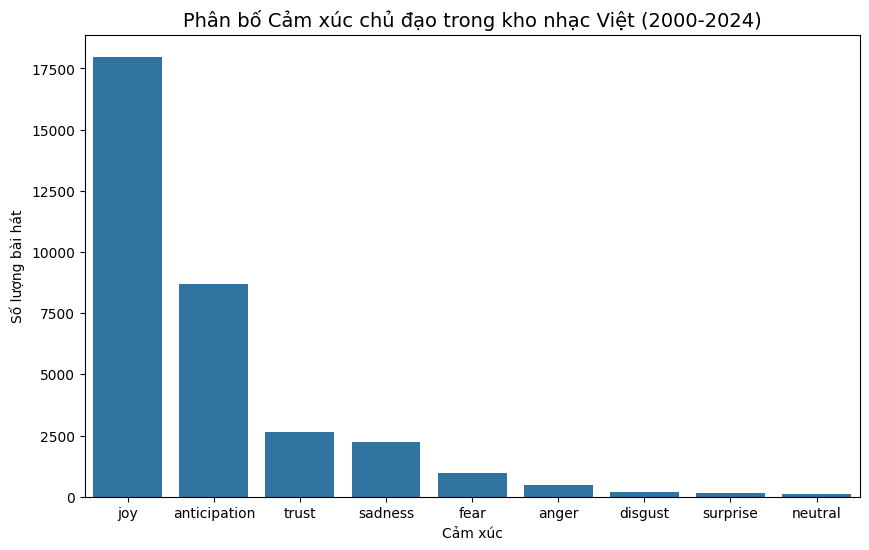

In [20]:
plt.figure(figsize=(10, 6))

emotion_counts = df_viz['top_emotion'].value_counts()

ax = sns.barplot(
    x=emotion_counts.index, 
    y=emotion_counts.values
)

plt.title('Phân bố Cảm xúc chủ đạo trong kho nhạc Việt (2000-2024)', fontsize=14)
plt.ylabel('Số lượng bài hát')
plt.xlabel('Cảm xúc')

plt.show()

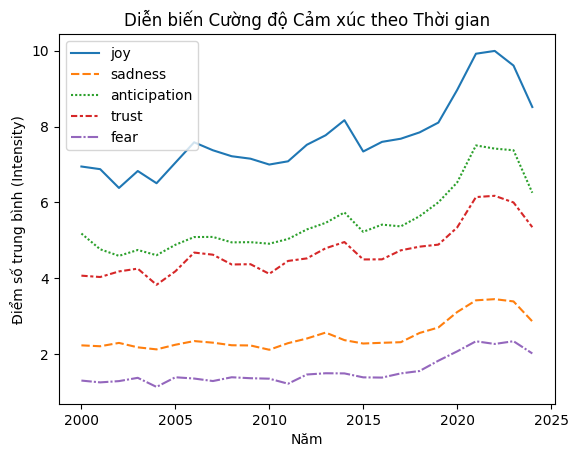

In [21]:
yearly_trends = df_viz.groupby('year')[['joy', 'sadness', 'anticipation', 'trust', 'fear']].mean()

sns.lineplot(data=yearly_trends)

plt.title('Diễn biến Cường độ Cảm xúc theo Thời gian')
plt.ylabel('Điểm số trung bình (Intensity)')
plt.xlabel('Năm')

plt.show()

In [22]:
emotion_list = [
    'anger', 'anticipation', 'disgust', 'fear', 
    'joy', 'sadness', 'surprise', 'trust'
]

df_genres = results.explode('genres')
df_genres = df_genres.groupby('genres')[emotion_list] \
                    .mean() \
                    .reset_index()

In [23]:
df_genres.head()

,genres,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
0,Ballad/Trữ Tình,0.638641,4.317421,0.586510,1.192732,6.148676,2.506472,1.303527,3.993825
1,Beat,0.715350,5.748137,0.618480,1.488823,7.958271,2.408346,1.250373,4.937407
2,Chill,0.761905,9.285714,1.095238,3.285714,11.380952,2.904762,2.333333,7.333333
3,Chế,1.000000,7.000000,1.000000,2.777778,7.333333,3.111111,1.444444,4.000000
4,Cách Mạng,0.788707,4.675774,0.395264,1.174863,8.464481,0.843352,2.444444,5.817851


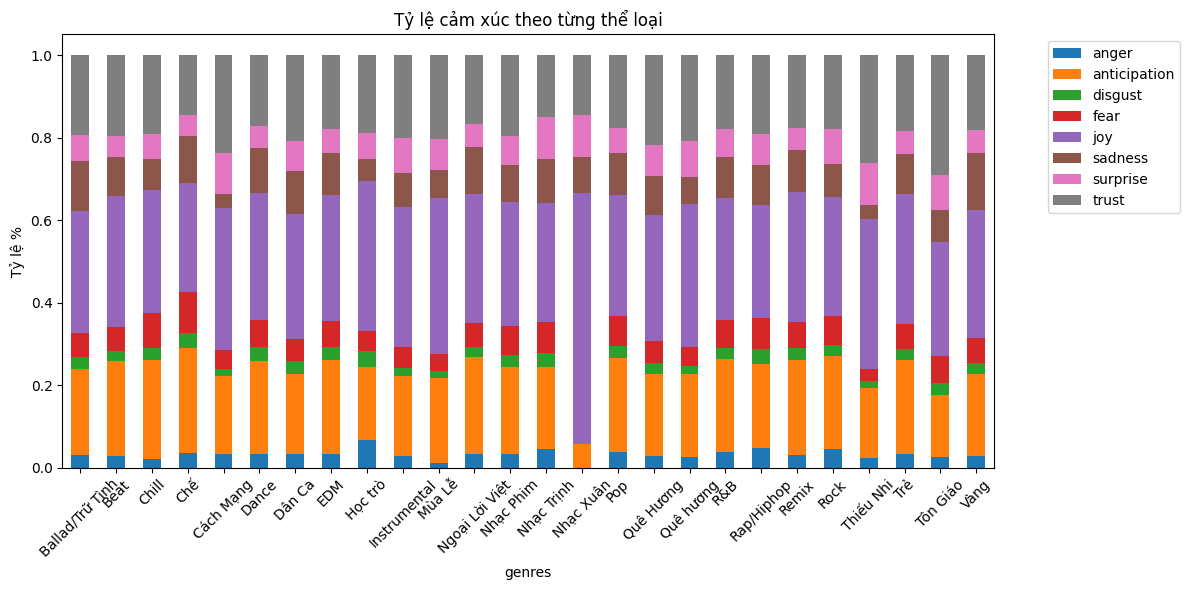

In [24]:
df_plot = df_genres.set_index('genres')
df_plot = df_plot.div(df_plot.sum(axis=1), axis=0)

df_plot.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 6)
)

plt.title('Tỷ lệ cảm xúc theo từng thể loại')
plt.ylabel('Tỷ lệ %')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

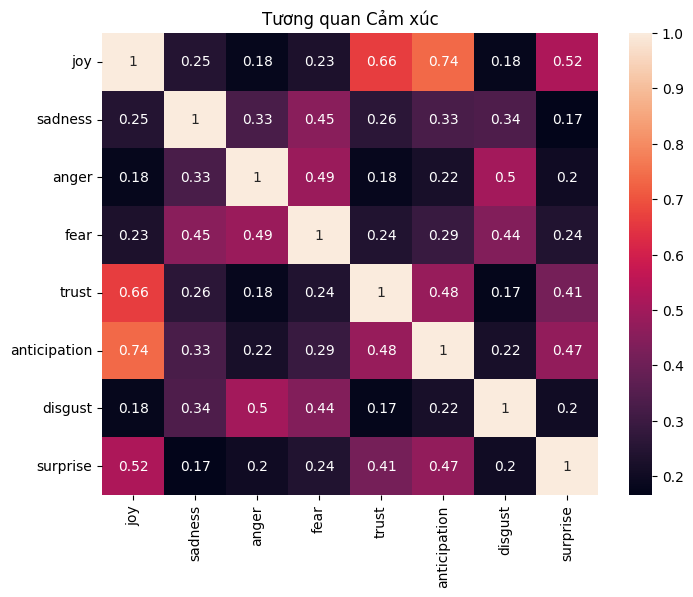

In [26]:
corr = df_viz[['joy', 'sadness', 'anger', 'fear', 'trust', 'anticipation', 'disgust', 'surprise']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True) 
plt.title('Tương quan Cảm xúc')
plt.show()

Text(0.5, 0, 'Cảm xúc')

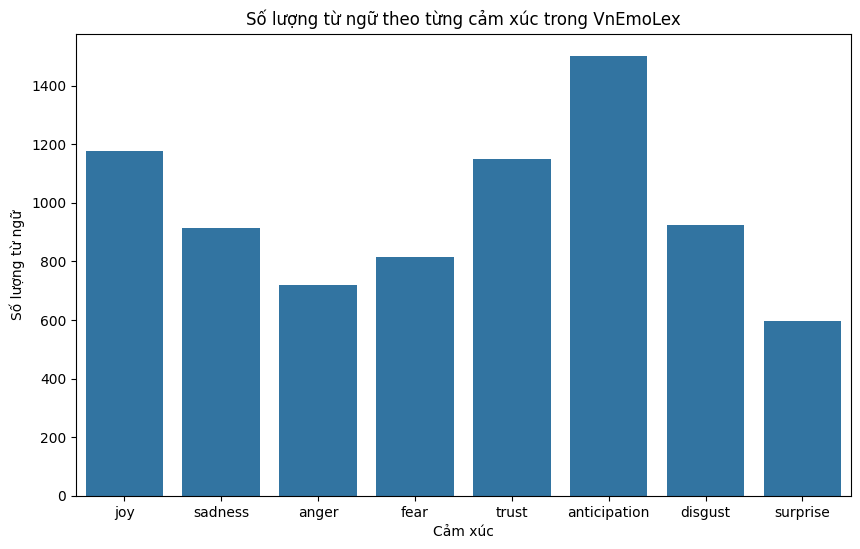

In [27]:
# Count words that have each emotion (a word can be counted for multiple emotions)
# e.g., if a word has joy=1 and sadness=1, it's counted in both

emotions = ['joy', 'sadness', 'anger', 'fear', 'trust', 'anticipation', 'disgust', 'surprise']

df = lexicon._load_dataframe()
word_counts = {emotion: df[emotion].sum() for emotion in emotions}
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Emotion', 'Word Count']) 

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Emotion', 
    y='Word Count', 
    data=word_counts_df
)
plt.title('Số lượng từ ngữ theo từng cảm xúc trong VnEmoLex')
plt.ylabel('Số lượng từ ngữ')
plt.xlabel('Cảm xúc')

/tmp/ipykernel_43872/2527734613.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Emotion', y='Word Count', data=word_counts_df, palette='viridis')


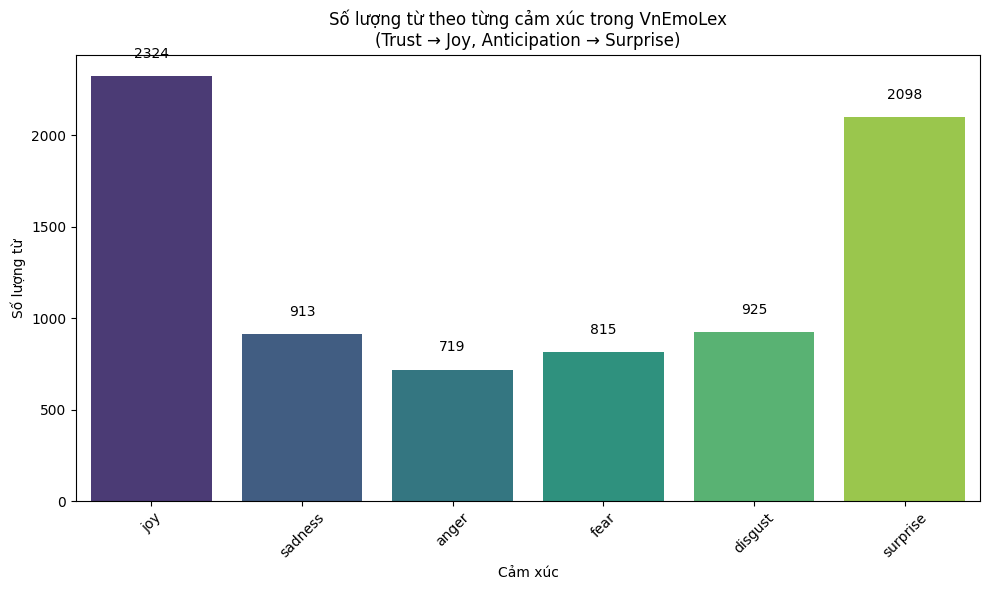


Joy có nhiều từ nhất: 2324 từ
So với trung bình: 1299 từ/cảm xúc


In [28]:
# Count words that have each emotion (a word can be counted for multiple emotions)
# Merge: trust -> joy, anticipation -> surprise (to match PhoBERT's 6 emotions)

df = lexicon._load_dataframe()

# Merge trust into joy and anticipation into surprise
word_counts = {
    'joy': (df['joy'] + df['trust']).sum(),
    'sadness': df['sadness'].sum(),
    'anger': df['anger'].sum(),
    'fear': df['fear'].sum(),
    'disgust': df['disgust'].sum(),
    'surprise': (df['surprise'] + df['anticipation']).sum()
}

word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['Emotion', 'Word Count']) 

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Emotion', y='Word Count', data=word_counts_df, palette='viridis')

# Add value labels on top of bars
for i, row in word_counts_df.iterrows():
    ax.text(i, row['Word Count'] + 100, str(int(row['Word Count'])), ha='center', fontsize=10)

plt.title('Số lượng từ theo từng cảm xúc trong VnEmoLex\n(Trust → Joy, Anticipation → Surprise)', fontsize=12)
plt.ylabel('Số lượng từ')
plt.xlabel('Cảm xúc')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nJoy có nhiều từ nhất: {word_counts['joy']} từ")
print(f"So với trung bình: {sum(word_counts.values()) / len(word_counts):.0f} từ/cảm xúc")